In [1]:
import sys, os, json
from collections import deque
from typing import Sequence, Tuple, List, Dict, Any
sys.path.append(os.getcwd())  

from polygon_generate_suite import load_polys_cases, generate_ploys
from viz_suite import render_ploys, render_hulls
from complexity_analysis import analyze_melkman_complexity

In [2]:
Point = Tuple[int, int]

def melkman_convex_hull(polygon: Sequence[Point],
                        verbose: bool = False,
                        stats: bool = False) -> List[Point] | Dict[str, Any]:
    # ---------- counters ----------
    C = dict(
        cross=0, orient=0,
        is_left=0, is_right_or_on=0,
        deq_append=0, deq_appendleft=0, deq_pop=0, deq_popleft=0,
        while_top_iters=0, while_bot_iters=0,
        inside_tests=0, comparisons=0   # 粗略计比较次数
    )

    # ---------- helpers ----------
    def cross(ax, ay, bx, by):
        C["cross"] += 1
        return ax*by - ay*bx

    def orient(a, b, c):
        C["orient"] += 1
        return cross(b[0]-a[0], b[1]-a[1], c[0]-a[0], c[1]-a[1])

    def is_left(a, b, c):
        C["is_left"] += 1
        C["comparisons"] += 1
        return orient(a, b, c) > 0

    def is_right_or_on(a, b, c):
        C["is_right_or_on"] += 1
        # 1 次 orient + 1 次比较计入
        C["comparisons"] += 1
        return orient(a, b, c) <= 0

    def fmtD(D: deque) -> str:
        return "[" + " | ".join(f"{i}:{p}" for i, p in enumerate(D)) + "]"

    def log(*args):
        if verbose: print(*args)

    # ---------- preprocess: 相邻去重 + 去掉重复首点 ----------
    pts: List[Point] = []
    for p in polygon:
        if not pts or p != pts[-1]:
            pts.append(p)
    if len(pts) >= 2 and pts[0] == pts[-1]:
        pts.pop()

    n = len(pts)
    log(f"[init] n={n}")
    log(f"[init] pts={pts}")
    if n == 0:
        log("[early-exit] empty")
        if stats: return {**C, "n": 0, "hull_len": 0, "total_ops": _total_ops(C)}
        return []
    if n == 1:
        log("[early-exit] single")
        if stats: return {**C, "n": 1, "hull_len": 1, "total_ops": _total_ops(C)}
        return [pts[0]]
    if n == 2:
        log("[early-exit] two")
        if stats: return {**C, "n": 2, "hull_len": 2, "total_ops": _total_ops(C)}
        return [pts[0], pts[1]]

    # ---------- 展开共线前缀，p1 指向前缀最后一个点 ----------
    p0 = pts[0]
    i1 = 1
    while i1 + 1 < n and orient(p0, pts[i1], pts[i1 + 1]) == 0:
        log(f"[collinear-prefix-extend] ({p0}) -> ({pts[i1]}) -> ({pts[i1+1]}) collinear; advance i1")
        i1 += 1
    p1 = pts[i1]
    log(f"[seed-edge] p0={p0}, p1={p1}  (seed base uses last collinear endpoint)")

    # 找首个非共线 p2 相对 p0,p1
    k = i1 + 1
    while k < n and orient(p0, p1, pts[k]) == 0:
        log(f"[seek-p2] k={k} {pts[k]} still collinear with seed edge")
        k += 1
    if k == n:
        lo = min(pts); hi = max(pts)
        hull = [lo, hi] if lo != hi else [lo]
        log("[all-collinear] hull=", hull)
        if stats: return {**C, "n": n, "hull_len": len(hull), "total_ops": _total_ops(C)}
        return hull

    p2 = pts[k]
    o = orient(p0, p1, p2)
    log(f"[seed-triple] p2={p2}, orient={o} -> {'CCW' if o>0 else 'CW'}")

    # ---------- 初始化 D：使 P0,P1,P2 在 D 中为 CCW，且 P2 同时在 top/bot ----------
    D = deque()
    if o > 0:
        D.append(p2); C["deq_append"] += 1
        D.append(p0); C["deq_append"] += 1
        D.append(p1); C["deq_append"] += 1
        D.append(p2); C["deq_append"] += 1
        log("[D-init-CCW] D=", fmtD(D))
    else:
        D.append(p2); C["deq_append"] += 1
        D.append(p1); C["deq_append"] += 1
        D.append(p0); C["deq_append"] += 1
        D.append(p2); C["deq_append"] += 1
        log("[D-init-CW->fix] D=", fmtD(D))

    # ---------- 扫描 i = k+1..n-1 ----------
    for i in range(k + 1, n):
        p = pts[i]
        log(f"\n[scan] i={i}, p={p}")

        C["inside_tests"] += 1
        in_top = is_left(D[-2], D[-1], p)
        in_bot = is_left(D[0], D[1], p)
        log(f"[inside-test] left(top {D[-2]}->{D[-1]})={in_top}, left(bot {D[0]}->{D[1]})={in_bot}")
        if in_top and in_bot:
            log("[action] inside -> skip")
            continue

        # 底部调整
        while is_right_or_on(D[0], D[1], p):
            removed = D.popleft(); C["deq_popleft"] += 1; C["while_bot_iters"] += 1
            log(f"[pop-bot] removed={removed}; D={fmtD(D)}")
        D.appendleft(p); C["deq_appendleft"] += 1
        log(f"[push-bot] insert {p}; D={fmtD(D)}")

        # 顶部调整
        while is_right_or_on(D[-2], D[-1], p):
            removed = D.pop(); C["deq_pop"] += 1; C["while_top_iters"] += 1
            log(f"[pop-top] removed={removed}; D={fmtD(D)}")
        D.append(p); C["deq_append"] += 1
        log(f"[push-top] append {p}; D={fmtD(D)}")

    # ---------- 收尾 ----------
    dup = D.pop(); C["deq_pop"] += 1
    log(f"\n[finalize] pop tail duplicate={dup}")
    hull = list(D)
    log("[hull] =", hull)

    if stats:
        C_out = {**C, "n": n, "hull_len": len(hull), "total_ops": _total_ops(C)}
        return C_out
    return hull


def _total_ops(C: Dict[str, int]) -> int:
    # 可按需调整计数定义
    return (
        C["cross"] + C["orient"] +
        C["is_left"] + C["is_right_or_on"] +
        C["deq_append"] + C["deq_appendleft"] + C["deq_pop"] + C["deq_popleft"]
    )

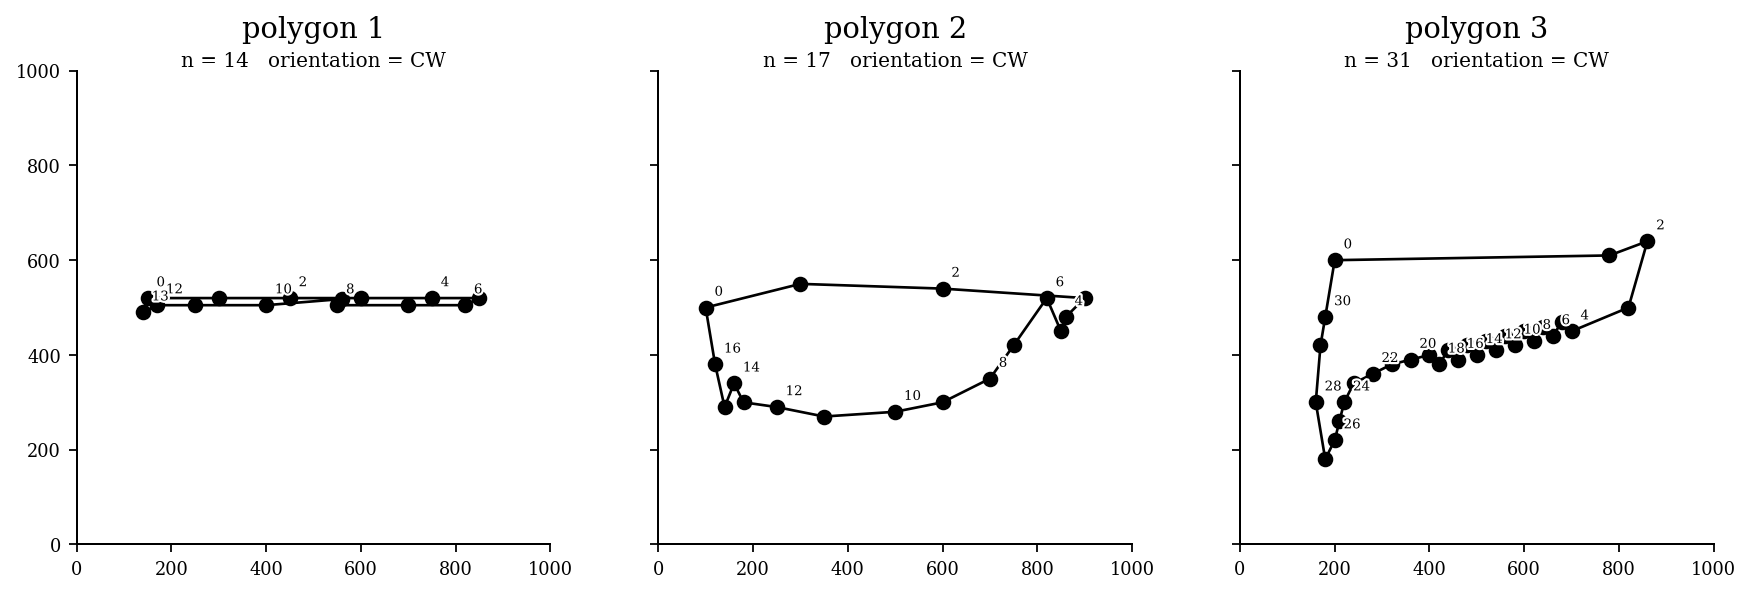

[init] n=14
[init] pts=[(150, 520), (300, 520), (450, 520), (600, 520), (750, 520), (850, 520), (820, 505), (700, 505), (550, 505), (560, 518), (400, 505), (250, 505), (170, 505), (140, 490)]
[collinear-prefix-extend] ((150, 520)) -> ((300, 520)) -> ((450, 520)) collinear; advance i1
[collinear-prefix-extend] ((150, 520)) -> ((450, 520)) -> ((600, 520)) collinear; advance i1
[collinear-prefix-extend] ((150, 520)) -> ((600, 520)) -> ((750, 520)) collinear; advance i1
[collinear-prefix-extend] ((150, 520)) -> ((750, 520)) -> ((850, 520)) collinear; advance i1
[seed-edge] p0=(150, 520), p1=(850, 520)  (seed base uses last collinear endpoint)
[seed-triple] p2=(820, 505), orient=-10500 -> CW
[D-init-CW->fix] D= [0:(820, 505) | 1:(850, 520) | 2:(150, 520) | 3:(820, 505)]

[scan] i=7, p=(700, 505)
[inside-test] left(top (150, 520)->(820, 505))=False, left(bot (820, 505)->(850, 520))=True
[push-bot] insert (700, 505); D=[0:(700, 505) | 1:(820, 505) | 2:(850, 520) | 3:(150, 520) | 4:(820, 505)]

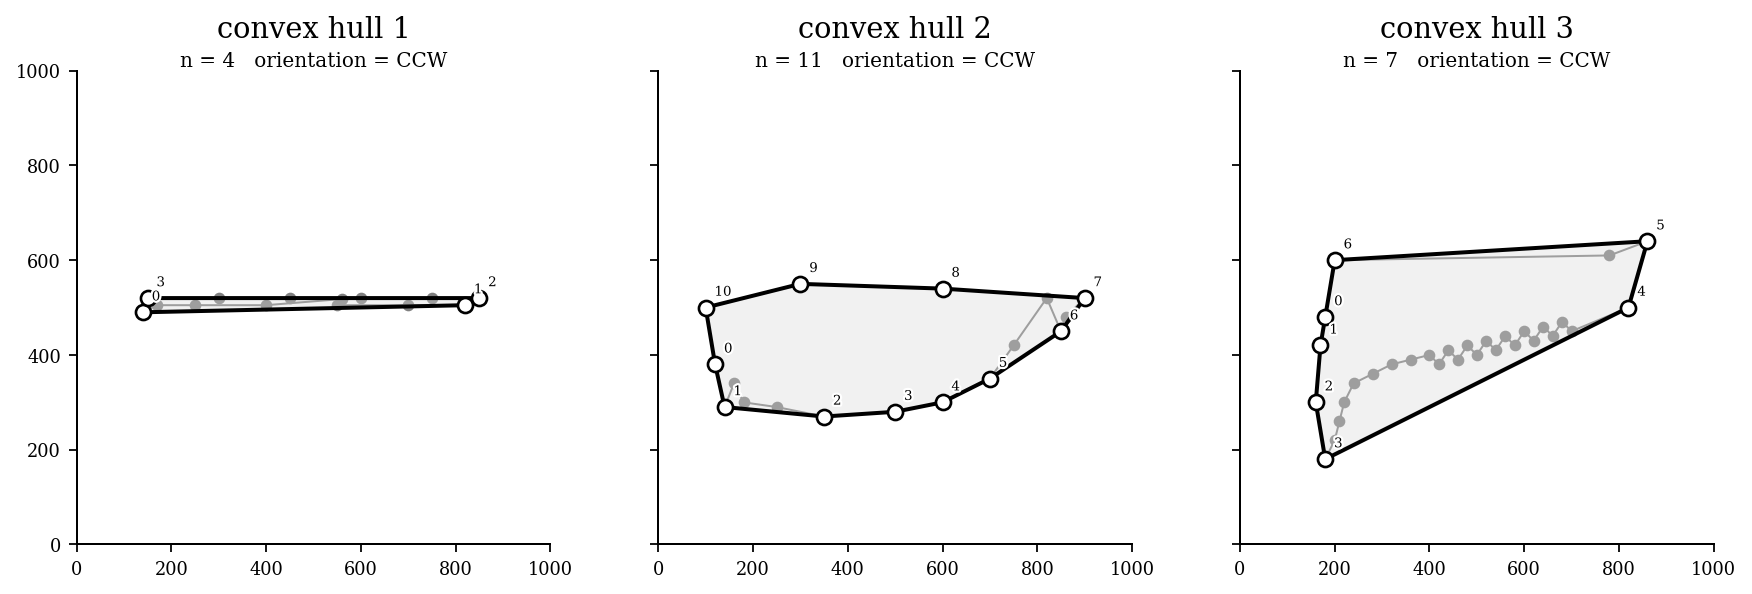

In [ ]:
Polys = load_polys_cases()
render_ploys(ploys = Polys, mark_every = 2, coord_range = 1000, cols_per_row = 3)

Hulls = [melkman_convex_hull(poly,verbose=True) for poly in Polys]
render_hulls(hulls = Hulls, polys = Polys, mark_every_poly = 0, mark_every_hull= 1, coord_range = 1000, cols_per_row = 3)

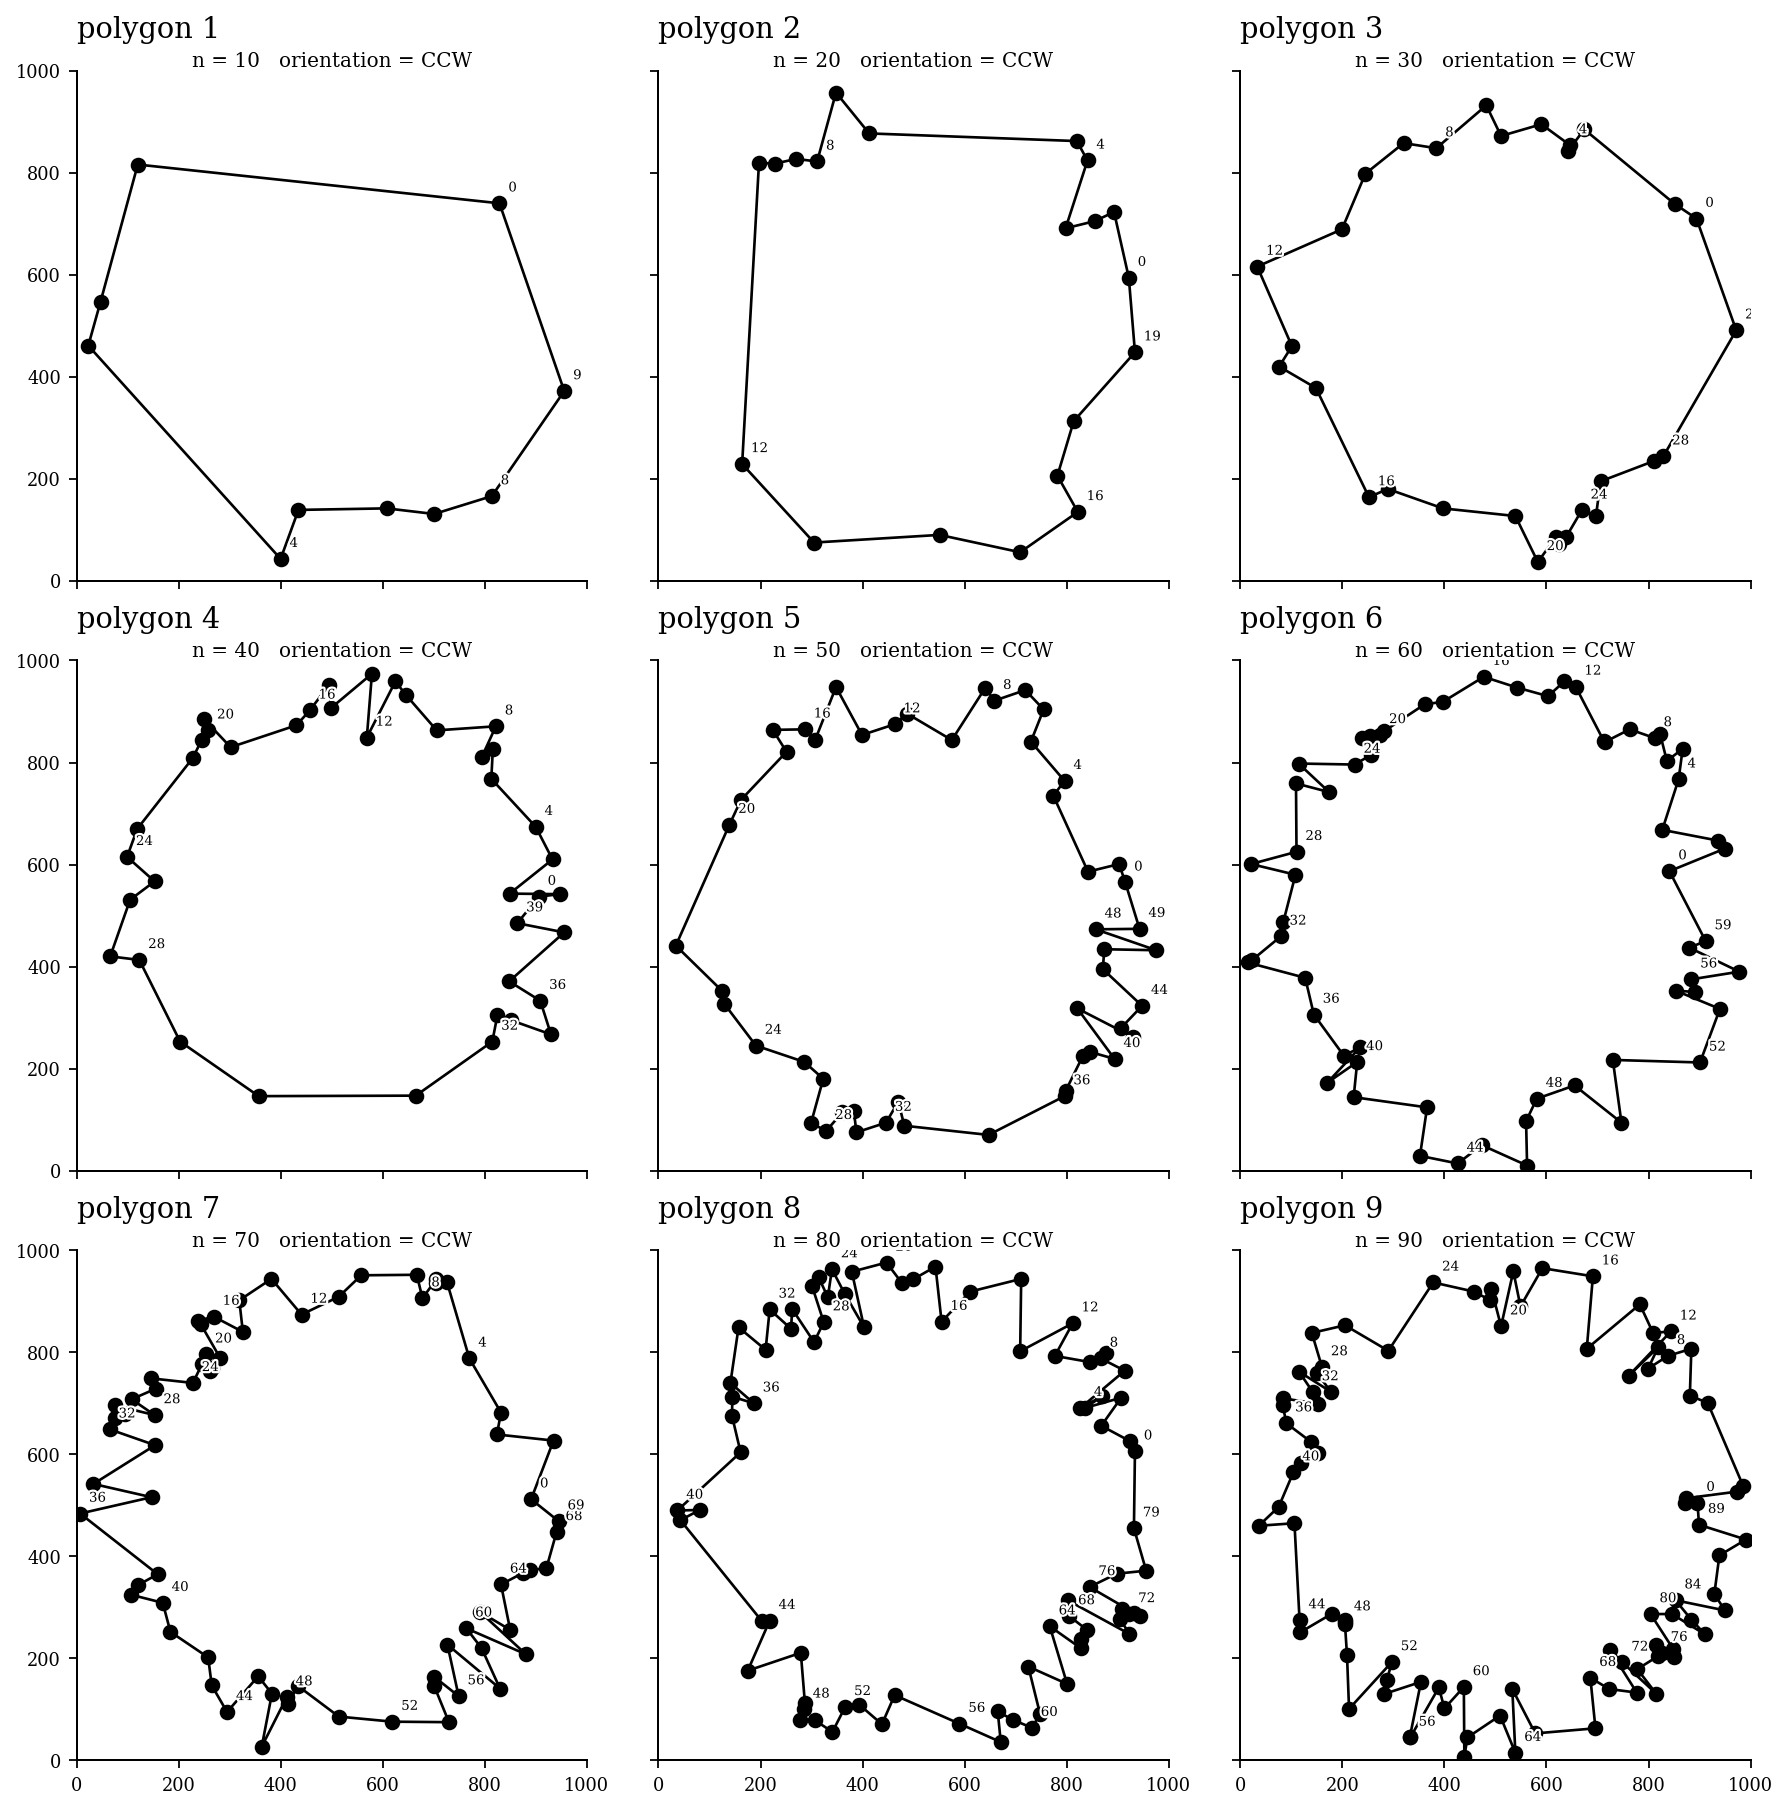

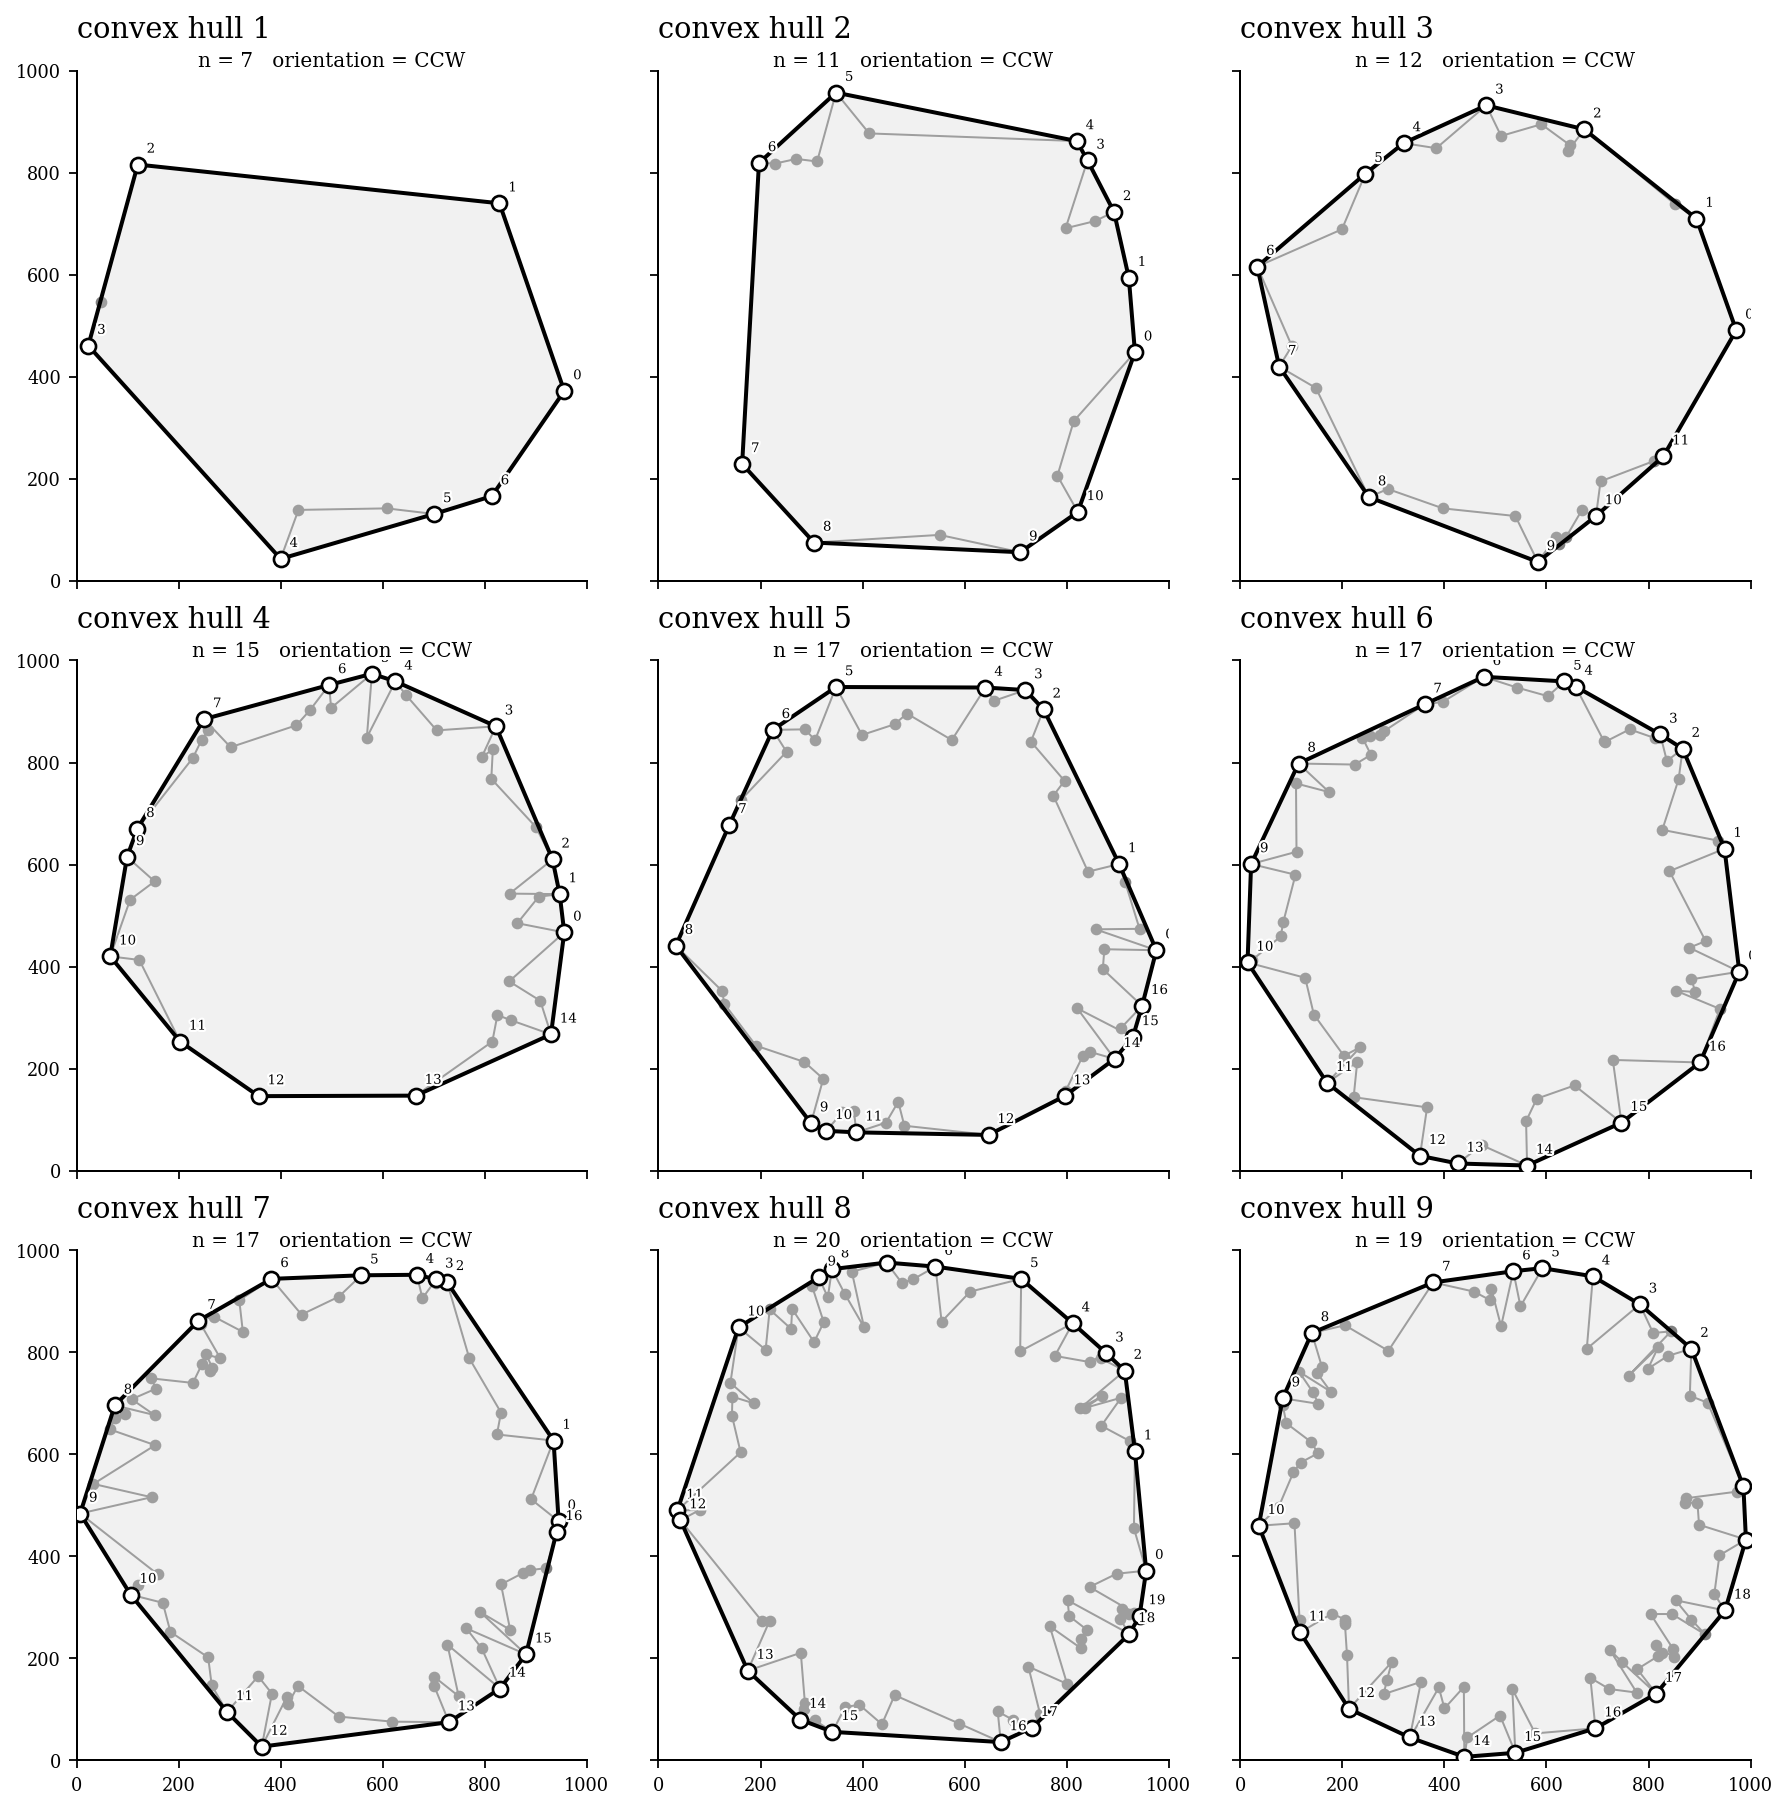

In [6]:
TestPolys = generate_ploys(sizes=[10, 20, 30, 40, 50, 60, 70, 80, 90],
                           image_size=1000, retries=500, seed=1024)
render_ploys(ploys=TestPolys, mark_every=4, coord_range=1000, cols_per_row=3)

TestHulls = [melkman_convex_hull(poly) for poly in TestPolys]
render_hulls(hulls = TestHulls, polys = TestPolys, mark_every_poly = 0, mark_every_hull= 1, coord_range = 1000,cols_per_row = 3)

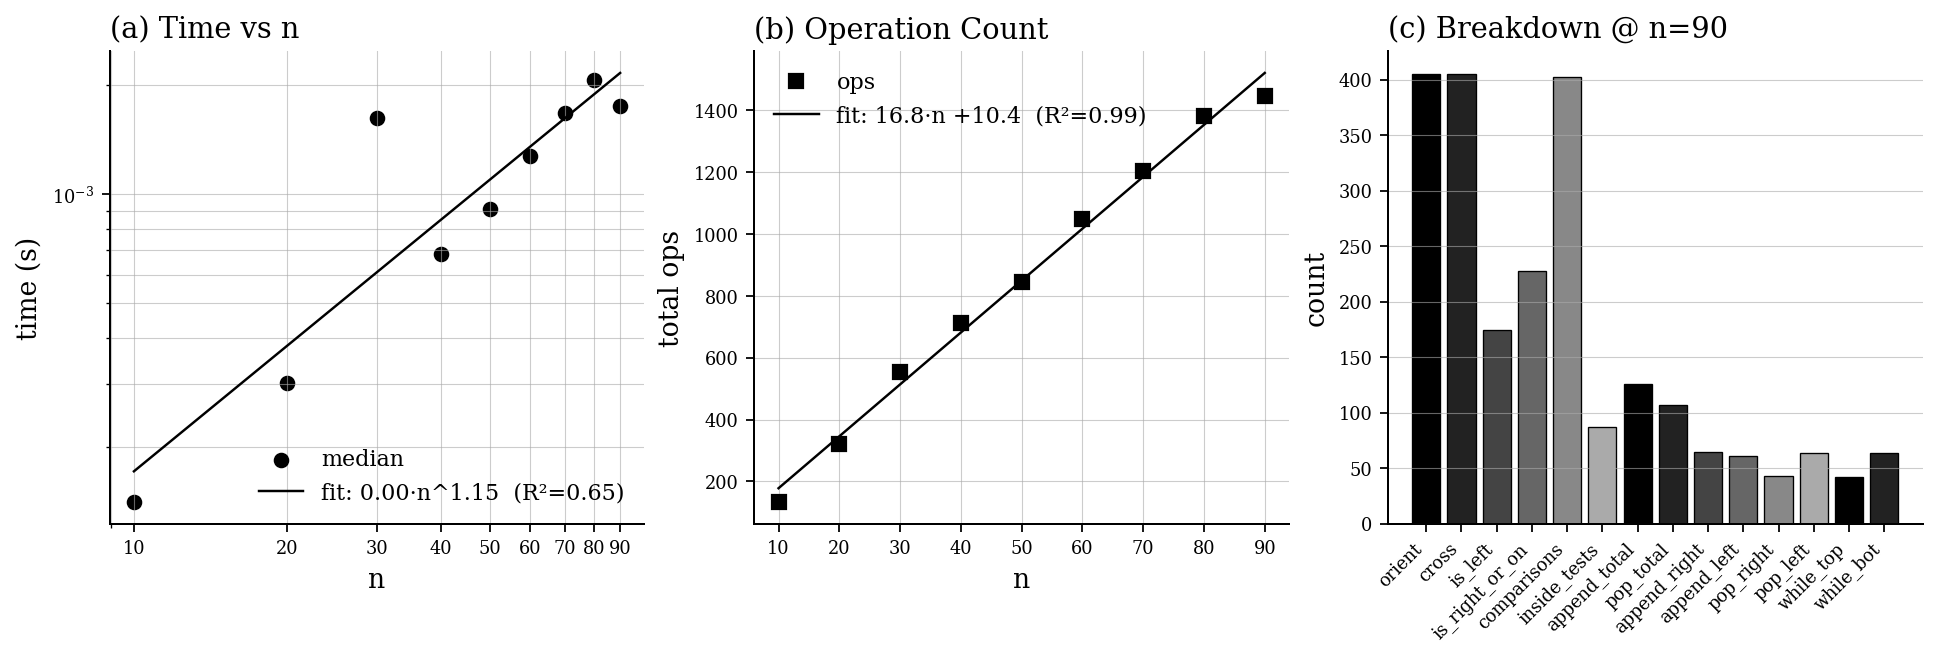

In [5]:
rep = analyze_melkman_complexity(TestPolys, melkman_convex_hull, runs=5, show=True)